# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train.shape

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


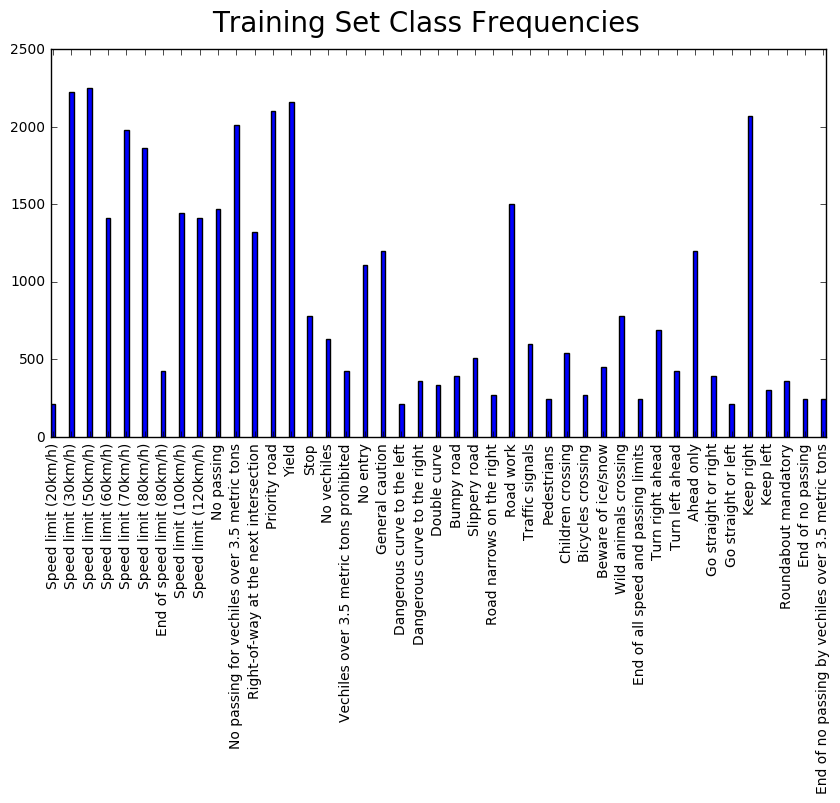

In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import csv
import numpy as np

label_names = {}
with open('signnames.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        label_names[row[0]] = row[1]

labelArray = []
label_classes = []
for i in range(43):
    labelArray.append(label_names[str(i)])
    label_classes.append(i)
# print (labelArray)
label_count = np.zeros((43),int)
# print(label_count)
for label in y_train:
#     print(label)
    label_count[label] += 1
# print (label_count)

# fig, ax = plt.subplots()
# # ax.set_xticklabels(labelArray)
# fig.set_size_inches(10,5)
# # fig.canvas.draw()
# # plt.xticks(label_count, labelArray, rotation='vertical')
# # plt.hist(label_count,43,alpha=0.5)

# fig.suptitle('Training Set Class Frequencies', fontsize=20)
# # plt.plot(label_classes, label_count)
# plt.bar(label_classes, label_count, align='center', width=0.25)
# plt.xticks(label_classes, labelArray, rotation='vertical')


# plt.show()
# # plt.plot(labelArray, label_count)
fig, ax = plt.subplots()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_xticklabels(labelArray)
fig.set_size_inches(10,5)
# fig.canvas.draw()
plt.xticks(label_count, labelArray, rotation='vertical')
# plt.hist(label_count,43,alpha=0.5)

fig.suptitle('Training Set Class Frequencies', fontsize=20)

plt.bar(label_classes, label_count, align='center', width=0.25)
plt.xticks(label_classes, labelArray, rotation='vertical')


plt.show()

## Above, I create a visualization for how much training data exists for each possible classification. We see that for some classifications, we have significantly fewer samples than others.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import cv2


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#could also do cv2.grayscale right here
X_train_gray = np.empty((0, 32, 32, 1))

#     print (img.shape)
# image = cv2.cvtColor(X_train[0], cv2.COLOR_RGB2GRAY)
# #     print('test')
# plt.figure()
# plt.imshow(image)
    
print ('woo')
    
#     numpy.append(X_train_gray, image, axis=0)
X_train /= 255 #normalizing data
X_test /= 255


# greyscale_X = tf.image.rgb_to_grayscale(X_train)




woo


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** The data is normalized on a scale of 0-1 while retaining its color properties.

In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

batches = 64

inputShape = X_train[0].shape[0] *  X_train[0].shape[1] *  X_train[0].shape[2]
print (inputShape)
def architecture(x):
    WeightConv1 = tf.Variable(tf.truncated_normal(shape=(5,5,3,6)))
    WeightBias1 = tf.Variable(tf.constant(0.0, shape=(6,)))
    conv1 = tf.nn.conv2d(x, WeightConv1, strides=[1,1,1,1], padding='VALID') + WeightBias1
    
    conv1 = tf.nn.relu(conv1)
    
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16)))
    conv2_b = tf.Variable(tf.constant(0.0, shape=(16,)))
    conv2 = tf.nn.conv2(conv1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    fc1 = flatten(conv2)
    
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)
    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.constant(0.0, shape=(120,)))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)
    
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 43)))
    fc2_b = tf.Variable(tf.constant(0.0, shape=(43,)))
    return tf.matmul(fc1, fc2_W) + fc2_b

    
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def conv_layer(input_layer,
               num_input_channels,
               kernel_size,
               num_filters,
               padding = 'VALID',
               use_pooling=True):

    shape = [kernel_size, kernel_size, num_input_channels, num_filters]

    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input_layer,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding=padding)

    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding=padding)
    layer = tf.nn.relu(layer)
    return layer

def fc_layer(input_layer,
            num_inputs,
            num_outputs,
            use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input_layer, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def conv_net(x, weights, biases):
    # Layer 1 - 28*28*1 to 14*14*32
    #new layer 1 – 32 * 32 * 3 –> 16 * 16 * 100
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    print(conv1.get_shape)
    conv1 = maxpool2d(conv1)

    # Layer 2 - 14*14*32 to 7*7*64
    #new layer 2 – 16 * 16 * 100 –> 8 * 8 * 150
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    print(conv2.get_shape)
    conv2 = maxpool2d(conv2)

    # Layer 3 - 7*7*64 to 4*4*128
    #new layer 3 – 8 * 8 * 150 –> 4 * 4 * 250
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)

    # Fully connected layer - 4*4*128 to 512
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)

    # Output Layer - class prediction - 512 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

def dense_to_one_hot(labels, n_classes):
    labels = np.array(labels)
    n_labels = labels.shape[0]
    index_offset = np.arange(n_labels) * n_classes
    labels_one_hot = np.zeros((n_labels, n_classes), dtype=np.float32)
    labels_one_hot.flat[index_offset + labels.ravel()] = 1
    return labels_one_hot

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def DNN(X):
    layer_1 = conv_layer(input_layer=features,
                         num_input_channels=3,
                         kernel_size=7,
                         num_filters=100,
                         padding = 'VALID',
                         use_pooling=True
                         )

    layer_2 = conv_layer(input_layer=layer_1,
                         num_input_channels=100,
                         kernel_size=4,
                         num_filters=150,
                         padding = 'VALID',
                         use_pooling=True
                         )
    layer_3 = conv_layer(input_layer=layer_2,
                         num_input_channels=150,
                         kernel_size=4,
                         num_filters=250,
                         padding = 'VALID',
                         use_pooling=True
                         )

    layer_3_flat, layer_3_flat_count = flatten_layer(layer_3)

    layer_4 = fc_layer(input_layer = layer_3_flat,
                       num_inputs = layer_3_flat_count,
                       num_outputs = 300,
                       use_relu=True)

    layer_4 = tf.nn.dropout(layer_4, keep_prob=0.5)

    layer_5 = fc_layer(input_layer=layer_4,
                       num_inputs=300,
                       num_outputs=n_classes,
                       use_relu=True)
    return layer_5

3072


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** Input 32\*32\*3 –> Conv 26\*26\*100 –> Max Pool 13\*13\*100 –> Relu 13\*13\*100 –> Conv 10\*10\*150 –> Max Pool 5\*5\*150 –> Relu 5\*5\*150 –> Conv 2\*2\*250  –> Max Pool 1\*1\*250 –> Relu 1\*1\*250 –> Fully Connected 300 neurons –> Dropout 300 neurons –> Fully Connected 43 neurons

This architecture was inspired by this research paper: http://people.idsia.ch/~juergen/nn2012traffic.pdf
However, the images were not resized to 48\*48 because this would not add useful information to any image that was originally smaller. A drop out layer was also added.

In [13]:
## Train your model here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
# x = tf.placeholder(tf.float32, (None, inputShape))
# # Classify over 10 digits 0-9.
# y = tf.placeholder(tf.float32, (None, 43))
# # Create the LeNet.
# fc2 = architecture(x)

# loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
# opt = tf.train.AdamOptimizer()
# train_op = opt.minimize(loss_op)
# correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
# accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

X_train, X_val, y_train, y_val = train_test_split(train['features'], train['labels'], test_size=0.05, random_state=0)
X_test, y_test = test['features'], test['labels']
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

# 0-255 -> 0-1
X_train /= 255
X_val /= 255
X_test /= 255

batch_size = 64
# number of traffic signs
n_classes = 43
epochs = 30
epoch = 0
input_shape = X_train.shape[1:]
learning_rate = 0.05
feature_size = 32*32*3


layer_width = {
    'layer_1': 100,
    'layer_2': 150,
    'layer_3': 250,
    'fully_connected': 300
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [7, 7, 3, layer_width['layer_1']])),
    'layer_2': tf.Variable(tf.truncated_normal(
        [2, 2, layer_width['layer_1'], layer_width['layer_2']])),
    'layer_3': tf.Variable(tf.truncated_normal(
        [4, 4, layer_width['layer_2'], layer_width['layer_3']])),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [4 * 4 * 250, layer_width['fully_connected']])),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes]))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

y_train = dense_to_one_hot(y_train, n_classes)

feature_size = 32*32*3


features = tf.placeholder(tf.float32, (None, 32,32,3), name="features")
labels = tf.placeholder(tf.int64, (None), name="labels")
print(features.get_shape)

#====from sec.29
# logits = conv_net(features, weights, biases)
logits = DNN(features)
# Define loss and optimizer
print(logits[1])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
#=====
#commented out to prevent overwriting of model.
# saver = tf.train.Saver()
init = tf.initialize_all_variables()

with tf.Session() as sess:
    
    sess.run(init)
    saver = tf.train.import_meta_graph("traffic-signs-model.meta")
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    for i in range(epochs):
        for offset in range(0, X_train.shape[0], batch_size):
#             print("Training images ", offset, " through ", offset+batch_size)
            end = offset + batch_size
            batch_X = X_train[offset:end]
            batch_y = y_train[offset:end]
#             print(batch_y.shape)
            bs = batch_X.shape[0]
#             print (bs)
#             batch_X = batch_X.reshape(bs, feature_size)
            batch_X = batch_X.reshape(bs, 32,32,3)
#             batch_y = batch_y.reshape(bs, n_classes)
            label_ones = np.zeros(shape=(64,43))
#         for label in range(len(batch_y)):
#               label_ones[label][batch_y[label]] = 1
            if(batch_X.shape[0] < 64):
                break
            sess.run(optimizer, feed_dict={features: batch_X, labels: batch_y})

#         val_l, val_acc = sess.run([loss, accuracy], feed_dict={features: X_val.reshape(X_val.shape[0], feature_size), labels: y_val})
        c = sess.run(cost, feed_dict={features: batch_X, labels: batch_y})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        saver.save(sess, 'traffic-signs-model')
        print("Model Saved")
        epoch += 1
#         print("Validation	Accuracy =", val_acc)
    print("Optimization Finished!")


# Test model
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    # Calculate accuracy
    y_test_matrix = dense_to_one_hot(y_test, n_classes)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    print("Accuracy:",accuracy.eval({features: X_test, labels: y_test_matrix}))
    

<bound method Tensor.get_shape of <tf.Tensor 'features:0' shape=(?, 32, 32, 3) dtype=float32>>
Tensor("strided_slice:0", shape=(43,), dtype=float32)
Epoch: 0001 cost= 0.510263860
Model Saved
Epoch: 0002 cost= 0.113406599
Model Saved
Epoch: 0003 cost= 0.059748702
Model Saved
Epoch: 0004 cost= 0.056352943
Model Saved
Epoch: 0005 cost= 0.022714797
Model Saved
Epoch: 0006 cost= 0.015689405
Model Saved
Epoch: 0007 cost= 0.001383630
Model Saved
Epoch: 0008 cost= 0.020063648
Model Saved
Epoch: 0009 cost= 0.005949677
Model Saved
Epoch: 0010 cost= 0.006353148
Model Saved
Epoch: 0011 cost= 0.002074264
Model Saved
Epoch: 0012 cost= 0.002562723
Model Saved
Epoch: 0013 cost= 0.001071231
Model Saved
Epoch: 0014 cost= 0.005962251
Model Saved
Epoch: 0015 cost= 0.000809113
Model Saved
Epoch: 0016 cost= 0.001197918
Model Saved
Epoch: 0017 cost= 0.000158116
Model Saved
Epoch: 0018 cost= 0.000811734
Model Saved
Epoch: 0019 cost= 0.000711664
Model Saved
Epoch: 0020 cost= 0.001160012
Model Saved
Epoch: 0021

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I trained it using a gradient descent optimizer, a batch-size of 64, 10 epochs, and a learning rate of 0.05. I used the gradient descent optimizer because it's the only one I understand right now.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** I didn't have a very strong understanding of how tensorflow would process data coming into this, 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

4


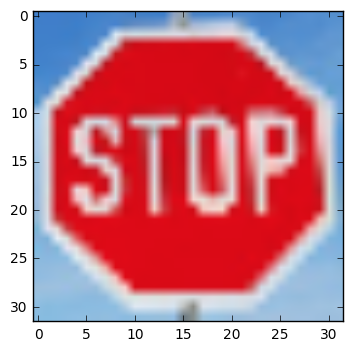

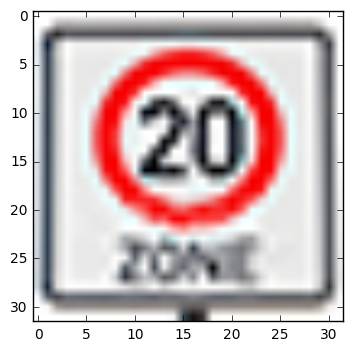

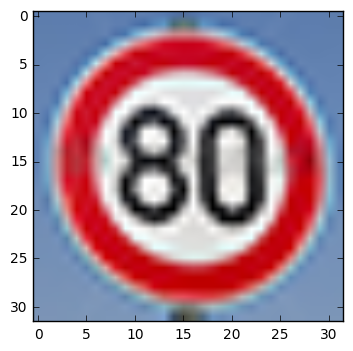

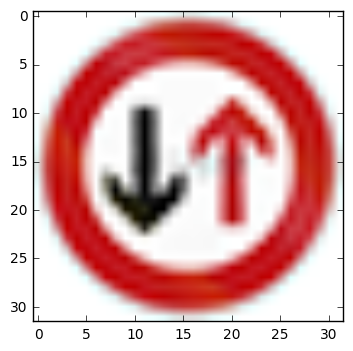

Tensor("labels:0", dtype=int64)


In [46]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
# print("Accuracy: ",accuracy.eval(session=sess, feed_dict={features: X_test, labels: y_test}))
import matplotlib.image as mpimg
import csv

def pre_process(image):
    image = cv2.resize(image, (32, 32))
    return image

test_images = ['stop.png','20.png','80.png', 'priority.png']
new_test = []
print(len(test_images))
for img in test_images:
    readImage = mpimg.imread(img)
    readImage = readImage[:,:,:3]
#     image = cv2.cvtColor(pre_process(readImage), cv2.COLOR_BGRA2BGR)
    image = pre_process(readImage)
    plt.figure()
    plt.imshow(image)
    new_test.append(image)
    plt.show()
    
    

print(labels)

        
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [48]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    new_saver = tf.train.import_meta_graph("traffic-signs-model.meta")
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
#     print (new_saver)
    prediction = tf.nn.softmax(logits)
    predictions = sess.run(prediction, {features: new_test})
    values, index = sess.run(tf.nn.top_k(prediction, 1), feed_dict={features: new_test})
#     print(predictions)
    index = 0
    for p in predictions:
#         print (p)
#         print(np.argmax(p))
        plt.figure()
        plt.imshow(new_test[index])
        index += 1
        print(label_names[str(np.argmax(p))])
    #for each prediction in predictions, sess.run(tf.nn.top_k(prediction, 1))
    

Pedestrians
Children crossing
Slippery road
Wild animals crossing


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.